# Resampling Methods for Model Selection
When it comes to selecting the best model for a given task we need a more robust method of evaluating predictive performance. 
In this notebook we will look at some techniques for how we choose to sample/resample our data and what effect this has on performance estimates. We will also see how these methods can be used for hyperparameter tuning.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Creating a dataset
Suppose we have a true function that we would like to estimate given by:

$$
f_\theta(x) = 1x + 0.1x^3
$$

In reality there is an unavoidable error, $\epsilon$, for example it could be error from measurement noise. Obviously as engineers we should be quite familiar with this. 

$$
y_\theta(x) = f_\theta(x) + \epsilon
$$

In [6]:
# Create arbitrary truth function
theta_true = [0, 1, 0, 0.1]
X = np.linspace(-10, 10, 1000).reshape(-1, 1)
y = theta_true[0] + theta_true[1]*X + theta_true[2]*X**2 + theta_true[3]*X**3

# Real data will have noise
X_set = np.random.uniform(-10, 10, 500)
y_set = theta_true[0] + theta_true[1]*X_set + theta_true[2]*X_set**2 + theta_true[3]*X_set**3 + np.random.normal(0, 10, 500)

## The Holdout Method
Up until this point we have chosen to split our data into two independant sets. The size of the original dataset guides the proportions of the split. If you holdout a large amount for testing (small amount for training) your test estimates may be *pessimistically biased*, as your model might have performed better if it were trained with more data. Decreasing the test set (increases training set) would help reduce this pessimistic bias, but now your test estimates may have increased variance, as you are using fewer examples to evaluate your model. Having fewer examples for evaluation causes high variance in the estimate because it depends on exaclt which examples ended up in the test split. 

The process would be as follows:

1. Randomly split the data into two sets. Training data to fit model parameters to, and holdout test data to act as unseen data to estimate a models predictive performance. 

2. Choose an appropraite learning algorithm and a fixed set of hyperparameters.

4. Fit a model on the training data using the chosen algorithm 

3. Evaluate on the test set to estimate generalization performance.

4. If you think the test estimate is good enough you could retrain your model on the entire dataset (training + test) - assuming it has not reached its full capacity with the limited training set.

We saw this in the Features and Regularization notebook, so I won't repeat it here, but we can quickly visualise a single split just to remind ourselves what the data looks like. 

In [7]:
# Basic train, test split to evaluate models.
# I've named the training set "learn" instead of "train" for reasons that will be clear later.
X_learn, X_test, y_learn, y_test = train_test_split(X_set, y_set, test_size=0.5, random_state=1)

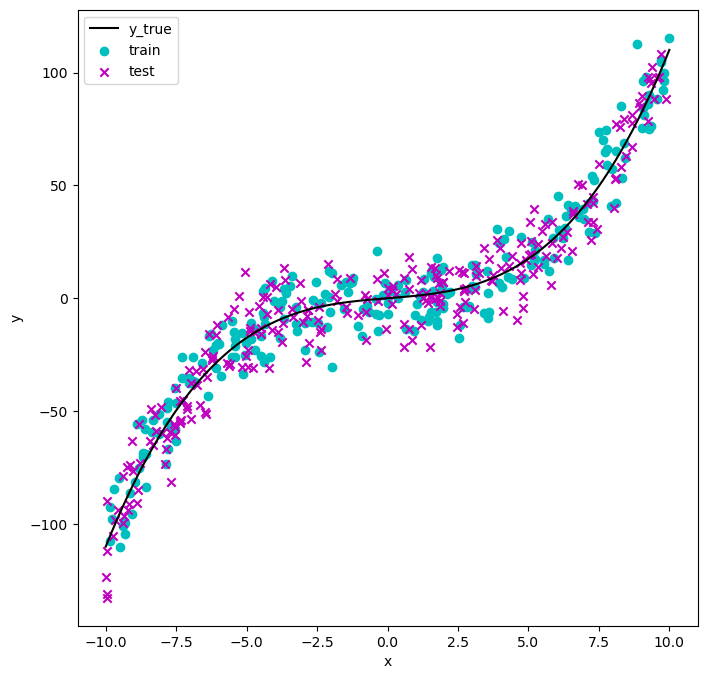

In [8]:
fig = plt.figure(figsize=(8, 8))
plt.plot(X, y, color='k', label='y_true')
plt.scatter(X_learn, y_learn, color='c', label='train')
plt.scatter(X_test, y_test, color='m', marker='x', label='test')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Repeated Holdout 
The estimate of a models performance might depend greatly on the exact split that was used for the data. By performing the holdout procedure only once we cannot be sure if the model has performed well/badly due to the specific examples that were in each set. We could make this more robust by simply performing multiple splits and performing the training and evaluation procedures on each of the new splits. This might also provide us with an idea of how stable the model is - if the test estimates vary greatly between each split then it may be a sign the model suffers from high variance. 




In [9]:
def repeatedHoldout(regressors, X, y, feature_transform, test_size=0.5, k=10):
    score_dict = {}
    for name, regressor in regressors.items():
        score_k = []
        for i in range(k):           
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
            
            if name != 'simple_reg':
                X_in = feature_transform.fit_transform(X_train.reshape(-1, 1))
                X_t = feature_transform.fit_transform(X_test.reshape(-1, 1))
            else:
                X_in = X_train.reshape(-1, 1)
                X_t = X_test.reshape(-1, 1)
            
            regressor.fit(X_in, y_train)
            score_k.append(regressor.score(X_t, y_test))
               
        score_dict[name] = score_k
        
    return score_dict

In [10]:
# Define learning algorithms
simple_reg = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
poly_reg = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
l1_reg = make_pipeline(StandardScaler(with_mean=False),Lasso(alpha=0.1, max_iter=10000))
l2_reg = make_pipeline(StandardScaler(with_mean=False),Ridge(alpha=0.1, max_iter=10000))

regressors = {
    'simple_reg': simple_reg,
    'poly_reg': poly_reg,
    'l1_reg': l1_reg,
    'l2_reg': l2_reg
}

poly = PolynomialFeatures(degree=25, include_bias=False)

In [11]:
k = 50
repeated_holdout_scores = repeatedHoldout(regressors, X_set, y_set, poly, test_size=0.5, k=k)

We can plot these results out to visualise the performance for each regressor across multiple random splits of the data.

ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of labels (50).

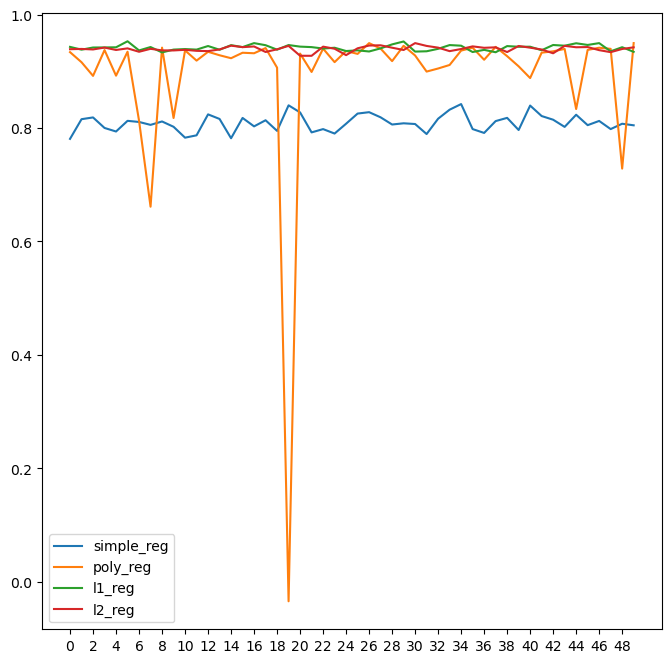

In [22]:
fig = plt.figure(figsize=(8, 8))
for i, (name, score) in enumerate(repeated_holdout_scores.items()):
    plt.plot(score, label=name)

plt.legend()
plt.xticks(np.arange(k, step=2), np.arange(k)+1)
plt.xlabel('Repetition #')
plt.ylabel('$r^2$ score')
plt.ylim(0.7, 1)
plt.show()


We can also use box-whisker plots to make the results easier to interpret,

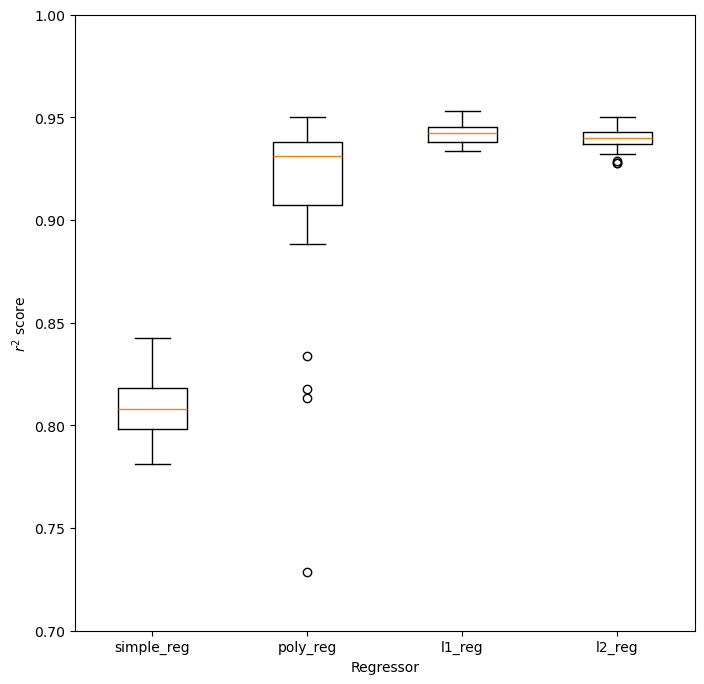

In [23]:
fig = plt.figure(figsize=(8, 8))
plt.boxplot(repeated_holdout_scores.values(), labels=repeated_holdout_scores.keys())
plt.ylabel('$r^2$ score')
plt.xlabel('Regressor')
plt.ylim(0.7, 1)
plt.show()

From these results we can see a few things.

The simple linear model fit on a single input feature has high bias (low scores on average) as expected and in this case it also has high variance (scores changed drastically depending on the split). 

The results for the standard linear regression model with no regularization, but fit on polynomial input features, stands out. If we only performed a single split we might have ended up with a seemingly good model (many $r^2$ scores compete with the regularized model scores), but this would be a poor estimate of generalization performance, as we can see there are also many cases where the specific splits caused significantly worse performance. 

Both the l1 and l2 regularized linear models show low bias and low variance compared to the other two models, with the l1 model performing slightly better which might also be expected as the sparsity it introduces results in a model that is closer to the true function.

## Information leak
With a repeated holdout the test data is not completely independant between splits because we are sampling randomly with replacement (some examples might appear in the test set multiple times). With this in mind it is possible that the estimates from the repeated holdout method would be overly optimistic because you could be evaluating the same examples at test time across multiple runs. One way we can produce better estimates is to use a three-way holdout method.

# Three-way Holdout 
The three-way holdout is an extension of the holdout methods that introduces an additional split, usually called a validation set. In total you would now have three separate sets: training, validation and test. 

- Training: The set used to determine how to update model parameters
- Validation: The set used to evaluate and compare different models, usually to compare the performance with different hyperparameters
- Test: The set used to evaluate the final model chosen based on the validation set performance. This provides an estimate of the generalization performance.  

The process would be as follows:

1. Split dataset into three parts: training, validation and test.
2. Fit model with specified hyperparameter values and evaluate on the validation set. 
3. Repeat step 2 with different hyperparameters.
4. Compare the validation performance of the trained models and choose the best performing model and set of hyperparameter values. Optionally train the chosen model with the best performing hyperparameters on the combined training + validation data.
5. Evaluate the generalization performance of the chosen model on the test set. 
6. If the test set performance is acceptable you can retrain on the entire dataset with the selected model and hyperparameters from step 4.

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_learn, y_learn, test_size=0.3)

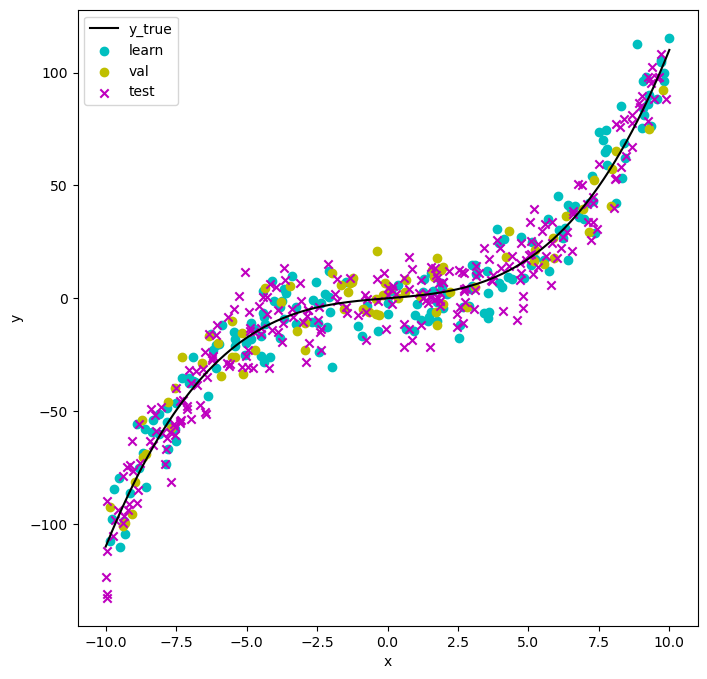

In [25]:
fig = plt.figure(figsize=(8,8))
plt.plot(X, y, color='black', linestyle='-', label='y_true')
plt.scatter(X_train, y_train, color='c', label='learn')
plt.scatter(X_val, y_val, color='y', label='val')
plt.scatter(X_test, y_test, color='m', marker='x', label='test')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [26]:
def threeWayHoldout(X, y, feature_transform, test_size=0.5, val_size=0.1):
    score_dict = {}
    X_learn, X_test, y_learn, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_learn, y_learn, test_size=val_size, random_state=1)
    
    X_train = feature_transform.fit_transform(X_train.reshape(-1, 1))
    X_val = feature_transform.fit_transform(X_val.reshape(-1, 1))
        
    alphas = np.logspace(-8, 1, num=10)
    for alpha in alphas:
        reg = Ridge(alpha=alpha, max_iter=10000)
        reg.fit(X_train, y_train)
        score_dict[alpha] = reg.score(X_val, y_val)
            
#         Or if you wanted to use the mean squared error
#         y_hat = reg.predict(X_val)
#         score_dict[alpha] = mean_squared_error(y_hat, y_val)
        
    return score_dict, X_learn, X_test, y_learn, y_test

In [27]:
score_dict, X_learn, X_test, y_learn, y_test  = threeWayHoldout(X_set, y_set, poly, test_size=4.0/5.0, val_size=0.3)

In [28]:
score_dict

{1e-08: -24997.118567351743,
 1e-07: -24960.091939373433,
 1e-06: -24594.327855883872,
 1e-05: -21341.86238366715,
 0.0001: -7554.8547661220855,
 0.001: -325.30728528159153,
 0.01: -11.135686924190226,
 0.1: -4.0559028021885055,
 1.0: -3.6531730076924553,
 10.0: -3.6035841485906897}

In [29]:
alpha = max(score_dict, key=score_dict.get)
l2_reg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=alpha, max_iter=10000))
l2_reg.fit(poly.fit_transform(X_learn.reshape(-1, 1)), y_learn)
poly_reg.fit(poly.fit_transform(X_learn.reshape(-1, 1)), y_learn)

l2_test_score = l2_reg.score(poly.fit_transform(X_test.reshape(-1, 1)), y_test)
poly_reg_score = poly_reg.score(poly.fit_transform(X_test.reshape(-1, 1)), y_test)

In [30]:
print("L2 test score: {}\nLinear test score: {}\n".format(l2_test_score, poly_reg_score))
                                                          

L2 test score: 0.9313735271295878
Linear test score: -199.5137698717518



In [31]:
y_hat_poly = poly_reg.predict(poly.fit_transform(X.reshape(-1, 1)))
y_hat_l2 = l2_reg.predict(poly.fit_transform(X.reshape(-1, 1)))

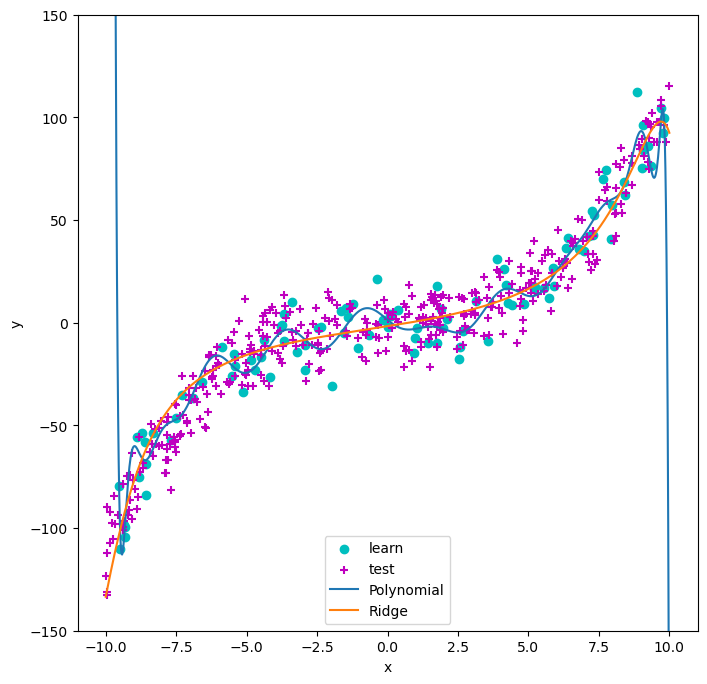

In [32]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_learn, y_learn, color='c', label='learn')
plt.scatter(X_test, y_test, color='m', marker='+', label='test')
plt.plot(X, y_hat_poly, label='Polynomial')
plt.plot(X, y_hat_l2, label='Ridge')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-150, 150)
plt.legend()
plt.show()

In [33]:
def getMSE(regressors, X, y, feature_transform):
    MSE_dict = {}
    for name, regressor in regressors.items():
        if name != 'simple_reg':
            X_in = feature_transform.fit_transform(X.reshape(-1, 1))
        else:
            X_in = X.reshape(-1, 1)
        y_hat = regressor.predict(X_in)
        MSE_dict[name] = mean_squared_error(y, y_hat)
        
    return MSE_dict

In [34]:
def printMSE(MSE_dict):
    for name, MSE in MSE_dict.items():
        print("{}: {}".format(name, MSE))

In [35]:
datasets = {'train': (X_train, y_train),
        'val': (X_val, y_val),
        'test': (X_test, y_test)}


for name, dataset in datasets.items():
    MSE_dict = getMSE(regressors, dataset[0], dataset[1], poly)
    
    print("MSE from: {} dataset".format(name))
    print(50*'-')
    printMSE(MSE_dict)
    print(50*'=')

MSE from: train dataset
--------------------------------------------------
simple_reg: 376.44959655872054
poly_reg: 33291.31447418719
l1_reg: 112.08372752008087
l2_reg: 109.71589291778663
MSE from: val dataset
--------------------------------------------------
simple_reg: 269.87623806549516
poly_reg: 48260.88227144747
l1_reg: 95.9393921537066
l2_reg: 94.77745820164975
MSE from: test dataset
--------------------------------------------------
simple_reg: 355.3164686825371
poly_reg: 379666.34420247114
l1_reg: 107.32302742183055
l2_reg: 103.79602153737841


What if we were to repeat this splitting of the data used for learning perhaps that would give us a better idea of the test set performance.




# k-Fold Cross-Validation
Performing a single split to validate the model has some problems. We do not know if the validation error was performing well due to the way the data was randomly split i.e. One particular split might yield good results based solely on the data that appeared in the split. Performing multiple random splits may provide 

To alleviate this issue we can simply repeat the splitting processing a number of times to get a better estimate. This process is called k-Fold Cross-Validation. Additionally we want to make sure that each time we split the data that we have completely new examples for validation. This ensures that over all folds every example is used for both training ($k-1$ times) and validation (once). If the data were split randomly some examples might be used for validation multiple times which may give a biased estimate of the generalization performance.  


In [36]:
from IPython.display import Image
#Image(filename='img/cv.png', retina=True)

In [37]:
def getCVScores(regressors, X_learn, y_learn, cv=5):
    score_dict = {}
    scoring = ["r2", "neg_mean_squared_error"]
    
    poly = PolynomialFeatures(degree=25, include_bias=False)
    
    for name, regressor in regressors.items():
        if name != 'simple_reg':
            X_in = poly.fit_transform(X_learn.reshape(-1, 1))
        else:
            X_in = X_learn.reshape(-1, 1)
            
        cv_scores = cross_validate(
            regressor, 
            X_in, 
            y_learn, 
            cv=cv, 
            scoring=scoring,
            return_estimator=True)

        score_dict[name] = {'test_r2': cv_scores['test_r2'],
                            'test_MSE': -cv_scores["test_neg_mean_squared_error"],
                            'estimators': cv_scores['estimator']}
    return score_dict

In [38]:
score_dict_5 = getCVScores(regressors, X_learn, y_learn, cv=5)
score_dict_10 = getCVScores(regressors, X_learn, y_learn, cv=10)

In [39]:
r2_scores_5 = [list(value['test_r2']) for value in list(score_dict_5.values())]
r2_scores_10 = [list(value['test_r2']) for value in list(score_dict_10.values())]

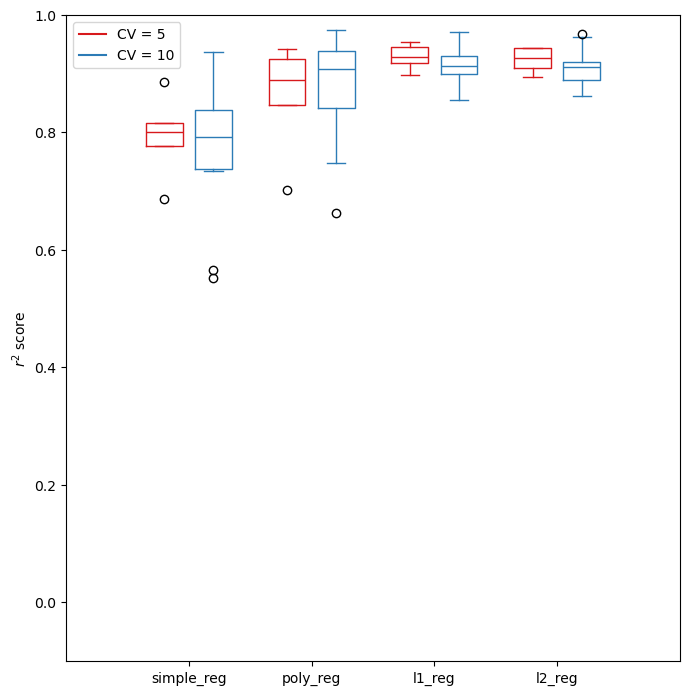

In [40]:
c1 = '#D7191C'
c2 = '#2C7BB6'
median_c = 'orange'
fig = plt.figure(figsize=(7, 7))

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], color=color)

bp1 = plt.boxplot(
    r2_scores_5, 
    positions=np.array(range(len(r2_scores_5)))*2.0-0.4, 
    widths=0.6,
)

bp2 = plt.boxplot(
    r2_scores_10, 
    positions=np.array(range(len(r2_scores_10)))*2.0+0.4, 
    widths=0.6,
)

set_box_color(bp1, c1)
set_box_color(bp2, c2)

plt.plot([], c=c1, label='CV = 5')
plt.plot([], c=c2, label='CV = 10')
plt.legend()
plt.ylabel('$r^2$ score')

ticks = list(score_dict_5.keys())
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
        
ymin = min(min(r2_scores_5 + r2_scores_10))
plt.ylim(0-0.1, 1)
plt.show()

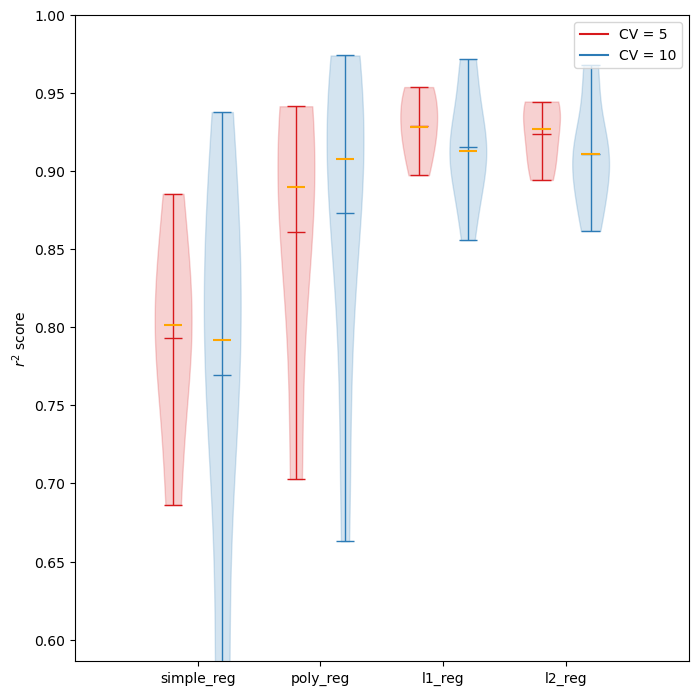

In [41]:
fig = plt.figure(figsize=(7, 7))

vp1 = plt.violinplot(
    r2_scores_5, 
    positions=np.array(range(len(r2_scores_5)))*2.0-0.4, 
    widths=0.6,
    showmeans=True,
    showmedians=True,
    showextrema=True
)

vp2 = plt.violinplot(
    r2_scores_10, 
    positions=np.array(range(len(r2_scores_10)))*2.0+0.4, 
    widths=0.6,
    showmeans=True,
    showmedians=True,
    showextrema=True
)

plt.plot([], c=c1, label='CV = 5')
plt.plot([], c=c2, label='CV = 10')
plt.legend()
plt.ylabel('$r^2$ score')

ticks = list(score_dict_5.keys())
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
        
ymin = min(min(r2_scores_5 + r2_scores_10))

def set_colour(plot, colour):
    for pc in plot['bodies']:
        pc.set_facecolor(colour)
        pc.set_edgecolor(colour)
        pc.set_alpha(0.2)
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = plot[partname]
        vp.set_edgecolor(colour)
        vp.set_linewidth(1)
    plot['cmedians'].set_edgecolor('orange')


set_colour(vp1, c1)
set_colour(vp2, c2)
    
    
plt.ylim(ymin-0.1, 1)
plt.show()